# Non LLM Based workflow

In [3]:
#State

from typing import TypedDict,Literal

class State(TypedDict):
    a:int
    b:int
    c:int

    equation: str
    Discriminant:float
    result:str
    summary:str


In [4]:
#Create the function to show the equation

def Equation(state: State):

    equation=f"equation = {state["a"]}x^2 {state['b']}x {state['c']}"

    return {"equation":equation}


Discriminant > 0: The equation has two distinct real roots.   
Discriminant = 0: The equation has exactly one real root (also known as a repeated or equal root).   
Discriminant < 0: The equation has two distinct imaginary roots (or no real roots). 

In [5]:
#For descriment

def Discriminant(state:State):

    #d=b*2-4ac
    d = ((state['b']**2) - 4*(state['a']*state['c']))

    return {"Discriminant":d}

def RealRoots(state:State):
     #x = (-b ± √D) / 2a
    r1= (-state['b'] + state['Discriminant']**0.5) /(2*state['a'])
    r2= (-state['b'] - state['Discriminant']**0.5) /(2*state['a'])

    result =f"Roots of are R1 = {r1} \n R2 = {r2} "

    return {"result":result}

def OneRealRoots(state: State):

    # x= -b/2a
    r = -(state["b"]) / 2*(state["a"])

    result =f"The equation has exactly one real root {r}"

    return {"result":result}

def NORealRoots(stae: State):
    
    result ="No real Roots"

    return {"result":result}

In [6]:
# add the condition
def conditional_condition(state:State) -> Literal["RealRoots","OneRealRoots","NORealRoots"]:
    if state["Discriminant"] > 0:
        return "RealRoots"
    elif state["Discriminant"] == 0:
        return {"OneRealRoot"}
    else:
        return {"NORealRoot"}
    

In [7]:
#StateGraph
from langgraph.graph import StateGraph,START,END

workflow=StateGraph(State)

In [8]:
workflow.add_node("Equation",Equation)
workflow.add_node("Discriminant",Discriminant)
workflow.add_node("RealRoots",RealRoots)
workflow.add_node("OneRealRoots",OneRealRoots)
workflow.add_node("NORealRoots",NORealRoots)

In [9]:

workflow.add_edge(START,"Equation")
workflow.add_edge("Equation","Discriminant")
workflow.add_conditional_edges("Discriminant",conditional_condition)

workflow.add_edge("RealRoots",END)
workflow.add_edge("OneRealRoots",END)
workflow.add_edge("NORealRoots",END)
graph=workflow.compile()

In [10]:
initial_input={"a":4,"b":-5,"c":-4}

In [11]:
graph.invoke(initial_input)

{'a': 4,
 'b': -5,
 'c': -4,
 'equation': 'equation = 4x^2 -5x -4',
 'Discriminant': 89,
 'result': 'Roots of are R1 = 1.8042476415070754 \n R2 = -0.5542476415070754 '}

# LLM Based Workflow

In [1]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
load_dotenv()
GROQ_API_KEY=os.environ.get("GROQ_API_KEY")

TRACELOOP_API_KEY= os.environ.get("TRACELOOP_API_KEY")

llm =ChatGroq(model ="llama-3.3-70b-versatile")

# Set inmemory llm cache
from langgraph.cache.memory import InMemoryCache

In [2]:
# Define the Schema
from pydantic import BaseModel, Field
from typing import Literal,TypedDict

class SentimentSchema(BaseModel):
    sentiment:Literal["Positive","Negative"] = Field(description = "Sentiment of the review")


class ReviewSchema(TypedDict):
    sentiment:Literal["Positive","Negative"]
    response:str
    review:str
    diagnosis:dict
    

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [3]:
model1=llm.with_structured_output(SentimentSchema)

model2=llm.with_structured_output(DiagnosisSchema)

In [22]:
def FindSentiment(state:ReviewSchema):
    prompt=f"For the following review find out the sentiment \n {state["review"]}"
    sentiment= model1.invoke(prompt).sentiment

    return {"sentiment":sentiment}

def check_condition(state: ReviewSchema) -> Literal["PositiveResponse","RunDiagnosis"]:

    if state["review"] == "positive":
        return "PositiveResponse"
    else:
        return "RunDiagnosis"

def PositiveResponse(state:ReviewSchema):
    prompt = f"""Write a warm thank-you message in response to this review:
    "{state['review']}"
    Also, kindly ask the user to leave feedback on our website.""" 
    
    response =llm.invoke(prompt).content

    return {"response":response}

def RunDiagnosis(state:ReviewSchema):
    prompt = f"""Diagnose this negative review: {state['review']}\n"
    "Return issue_type, tone, and urgency.
     """
    
    response = model2.invoke(prompt) # Return the JSON 

    return {"diagnosis":response.model_dump()} #return dict

def NegativeResponse(state:ReviewSchema):
    
    diagnosis=state["diagnosis"]
    prompt = f"""You are a support assistant.
        The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
        Write an empathetic, helpful resolution message.
        """
    response =llm.invoke(prompt).content
    return {"response":response}


In [23]:
from langgraph.graph import StateGraph,START,END
workflow=StateGraph(ReviewSchema)

workflow.add_node("sentiment",FindSentiment)
workflow.add_node("PositiveResponse",PositiveResponse)
workflow.add_node("RunDiagnosis",RunDiagnosis)
workflow.add_node("NegativeResponse",NegativeResponse)

workflow.add_edge(START,"sentiment")
workflow.add_conditional_edges("sentiment",check_condition)
workflow.add_edge("PositiveResponse",END)
workflow.add_edge("RunDiagnosis","NegativeResponse")
workflow.add_edge("NegativeResponse",END)

memory =InMemoryCache()
graph=workflow.compile(cache=memory)

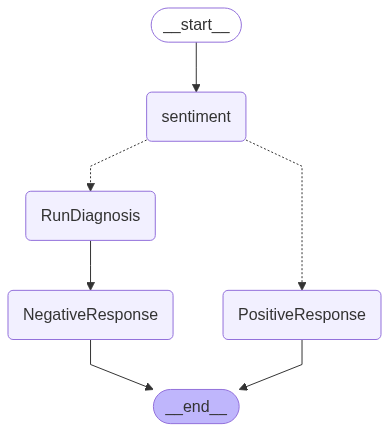

In [24]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [25]:
initial = {"review":'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',}
graph.invoke(initial)


{'sentiment': 'Negative',
 'response': "I'm so sorry to hear that you're experiencing a bug issue and that it's causing frustration for you. I can imagine how annoying and time-consuming it must be, and I want to assure you that I'm here to help resolve the issue as quickly as possible.\n\nI've marked this issue as high priority, and I'll do my best to provide a prompt and effective solution. Can you please provide me with more details about the bug, such as the steps you took leading up to the issue, any error messages you've received, and what you've tried so far to resolve it? This will help me better understand the problem and work towards a resolution.\n\nIn the meantime, I want to offer you a sincere apology for the inconvenience this has caused and appreciate your patience and cooperation. Your satisfaction is my top priority, and I'm committed to getting this issue resolved for you.\n\nIf there's anything else I can do to make things right, please don't hesitate to let me know.